In [1]:
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.fftpack import fft
import matplotlib.pyplot as plt

In [2]:
ROUNDING_SPECIFICITY = 4

from enum import Enum

class BaseNote(Enum):
    C = 16.35
    C_SHARP = 17.32
    D = 18.35
    D_SHARP = 19.45
    E = 20.60
    F = 21.83
    F_SHARP = 23.12
    G = 24.50
    G_SHARP = 25.96
    A = 27.50
    A_SHARP = 29.14
    B = 30.87
    
    
class Note:
    def __init__(self, note: BaseNote, octave: int, velocity: float = 1.0):
        self.note = note
        self.octave = octave
        self.velocity = velocity
        
    def __eq__(self, other):
        if isinstance(other, Note):
            return self.note == other.note and self.octave == other.octave
        return False
        
    def __hash__(self):
        return hash((self.note, self.octave))
        
    def get_frequency(self):
        return self.note.value * (2 ** self.octave)


class NoteRollNote:
    def __init__(self, note: Note, start_time: float, end_time: float = 0):
        self.note = note
        self.start_time = start_time
        self.end_time = end_time
        
        
    def __eq__(self, other):
        if isinstance(other, NoteRollNote):
            return self.note == other.note
        return False
        
        
    def __hash__(self):
        return hash(self.note)
    
    def generate_wave(self, sampling_frequency):
        duration = self.end_time - self.start_time
        t = np.linspace(0, duration, int(duration * sampling_frequency), False)
        wave = np.sin(2 * np.pi * self.note.get_frequency() * t)
        return wave * self.note.velocity
        

class NoteUtilities:
    def __init__(self):
        self.notes = list(BaseNote)

    @staticmethod
    @staticmethod
    def enumerate_circle_of_fifths(start_octave=0, end_octave=8):
        for octave in range(start_octave, end_octave + 1):
            for note in BaseNote:
                yield (BaseNote(note.value), note.value * (2 ** octave), octave)
                
                
    @staticmethod
    def get_note_from_frequency(frequency, start_octave= 0, end_octave = 8):
        
        closest_note: Note = None
        min_difference = float('inf')
        for base_note, note_frequency, octave in NoteUtilities.enumerate_circle_of_fifths(start_octave, end_octave):
            difference = abs(frequency - note_frequency)
            if difference < min_difference:
                min_difference = difference
                closest_note = Note(base_note, octave)
            
            # Break early, since we're now going away from the note frequency
            if difference > min_difference:
                break
            
        return closest_note
    
    @staticmethod
    def get_note_frequency_window_set(
        data: np.ndarray,
        sample_duration: float,
        sampling_frequency: int,
        threshold_intensity: float = 0.1,
    ):
        """
        Creates windows of notes for the input duration in the form [frequency, velocity].
        """

        windows = []
        samples_per_duration = int(sample_duration * sampling_frequency)

        for i in range(0, len(data), samples_per_duration):
            window = data[i : i + samples_per_duration]
            fft_spectrum = fft(window)
            frequencies = np.fft.fftfreq(len(fft_spectrum), 1 / sampling_frequency)
            magnitude = np.abs(fft_spectrum)

            sorted_magnitude_indices = np.argsort(magnitude)

            max_magnitude_index = sorted_magnitude_indices[-1]
            max_magnitude = magnitude[max_magnitude_index]
            min_magnitude = threshold_intensity * max_magnitude

            notes_magnitude_indices = np.where(magnitude > min_magnitude)

            note_frequencies = frequencies[notes_magnitude_indices]
            note_frequencies = note_frequencies[note_frequencies > 0]

            note_velocities = magnitude[notes_magnitude_indices]
            note_velocities = note_velocities[frequencies[notes_magnitude_indices] > 0]

            windows.append((note_frequencies, note_velocities))

        return windows

    def get_windowset_notes(noteset):
        
        note_sets = []
        for frequency_list, magnitude_list in noteset:
            notes: set[Note] = set()
            note_sets.append(notes)
            for frequency, magnitude in zip(frequency_list, magnitude_list):
                note = NoteUtilities.get_note_from_frequency(frequency)
                note.velocity = magnitude
                notes.add(note)
                
        return note_sets
    
    def get_note_roll(note_sets, window_frame_duration):
        note_roll: list[NoteRollNote] = []
        
        pending_notes: set[NoteRollNote] = set()
        
        time = 0
        for i, note_set in enumerate(note_sets):
            next_note_set = note_sets[i + 1] if i + 1 < len(note_sets) else set()
            
            # check the pending_notes note set. If the note is in the next note set, dont't do anything.
            # if it is not in the next note set, then remove it from the pending note set and add it to the note roll with end time of now.
            
            to_remove = set()
            for note in pending_notes:
                if note.note in next_note_set:
                    continue
                
                note.end_time = time
                note_roll.append(note)
                to_remove.add(note)
                
            pending_notes.difference_update(to_remove)
            
            for note in note_set:
                noll_note = NoteRollNote(note, time)
                if noll_note not in pending_notes:
                    pending_notes.add(noll_note)
            
            time += window_frame_duration
            time = round(time, ROUNDING_SPECIFICITY)
            
        note_roll = sorted(note_roll, key=lambda note: (note.start_time, note.end_time))
        return note_roll
    
    
    def create_wave(note_roll, sampling_frequency):
        length =  int(max(note.end_time for note in note_roll) * sampling_frequency)
        output = np.zeros(length)
        
        # Iterate through each note, generate its wave, calculate its start index, and ADD the wave's values to the existing values at its index.
        for note in note_roll:
            wave = note.generate_wave(sampling_frequency)
            start_index = int(note.start_time * sampling_frequency)
            output[start_index : start_index + len(wave)] += wave
        
    
        return output / np.max(output)



In [3]:
# Before I do this on song sections, let's make sure it works on a sine wave!

fs = 44_100
duration = 5

sine_frequency = 5000

n_samples = int(fs * duration)

x = np.linspace(0, duration, n_samples, endpoint=False)
y = np.sin(2 * np.pi * sine_frequency * x)


sinewave_noteset = NoteUtilities.get_note_frequency_window_set(y, 1, fs)

print(sinewave_noteset)

[(array([5000.]), array([22050.])), (array([5000.]), array([22050.])), (array([5000.]), array([22050.])), (array([5000.]), array([22050.])), (array([5000.]), array([22050.]))]


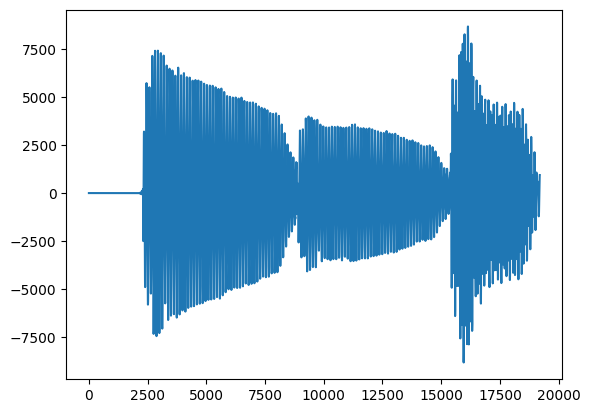

In [4]:
rate, song_data = wavfile.read("./data/song.wav")

mono_data = song_data

if song_data.shape[1] == 2:
    mono_data = np.average(song_data, axis=1)
    
    

time = 0.4 # seconds of audio
sample_at_time = rate * time
plot_fs = 10000
n_samples = int(time * plot_fs)

x = np.linspace(0, sample_at_time, n_samples).astype(np.int32)
y = mono_data[x]


plt.plot(x, y)
plt.show()

In [13]:
window_duration = 0.01
data_note_sets = NoteUtilities.get_note_frequency_window_set(mono_data, window_duration, rate, 0.2)

print(data_note_sets[0])

(array([], dtype=float64), array([], dtype=float64))


This works nicely, but the notes are very close in nature and don't give a nice representation of a musical note. Let's define our musical notation using some classes, then transform these arrays into musical notes by rounding their frequencies!

Let's test out our utilities on some sample frequencies!

In [6]:
close_to_c_octave_4 = NoteUtilities.get_note_from_frequency(261)
closer_to_c_sharp_octave_4 = NoteUtilities.get_note_from_frequency(270)
closer_to_a_sharp_octave_2 = NoteUtilities.get_note_from_frequency(116)

print(close_to_c_octave_4.note.name, close_to_c_octave_4.octave)
print(closer_to_c_sharp_octave_4.note.name, close_to_c_octave_4.octave)
print(closer_to_a_sharp_octave_2.note.name, closer_to_a_sharp_octave_2.octave)


C 4
C_SHARP 4
A_SHARP 2


In [7]:
print(sinewave_noteset)

note_sets = NoteUtilities.get_windowset_notes(sinewave_noteset)

for note_set in note_sets:
    for note in note_set:
        print(note.note.name, note.octave)

[(array([5000.]), array([22050.])), (array([5000.]), array([22050.])), (array([5000.]), array([22050.])), (array([5000.]), array([22050.])), (array([5000.]), array([22050.]))]
D_SHARP 8
D_SHARP 8
D_SHARP 8
D_SHARP 8
D_SHARP 8


Now, let's try this on the actual song sample!

In [14]:

note_sets = NoteUtilities.get_windowset_notes(data_note_sets)

for i, note_set in enumerate(note_sets[:10]):
    print(F"Set {i}:")
    for note in note_set:
        print(note.note.name, note.octave)

Set 0:
Set 1:
Set 2:
Set 3:
Set 4:
Set 5:
Set 6:
Set 7:
Set 8:
Set 9:


One problem here is we cannot estimate the note duration, but it would seem strange to replay the note over and over again just to keep the note going. So, we need that note to continue playing while it is in subsequent note sets. Ultimately, we need to be able to generate a set of notes, their start time, end times, and velocities.

Each note set's interval is determined by the length of time the window represents. Each note duration is represented by how many frames the note appears in in a row, and the velocity is already known. From this, we can create our list!

In [9]:
note_roll = NoteUtilities.get_note_roll(note_sets[0:100000], window_duration)

for note in note_roll[:10]:
    print(note.start_time, note.end_time, note.note.note.name, note.note.octave, note.note.velocity)    

0.0501 0.0502 B 8 0.5
0.0502 0.0504 B 8 1.118033988749895
0.0504 0.0505 B 8 1.0
0.0507 0.0508 B 8 1.4142135623730951
0.0508 0.0509 B 8 1.4142135623730951
0.0511 0.0512 B 8 1.0
0.0512 0.0513 B 8 1.0
0.0515 0.0516 B 8 1.0
0.0516 0.0517 B 8 1.4142135623730951
0.0521 0.0522 B 8 1.0


ValueError: x and y must have same first dimension, but have shapes (4,) and (9,)

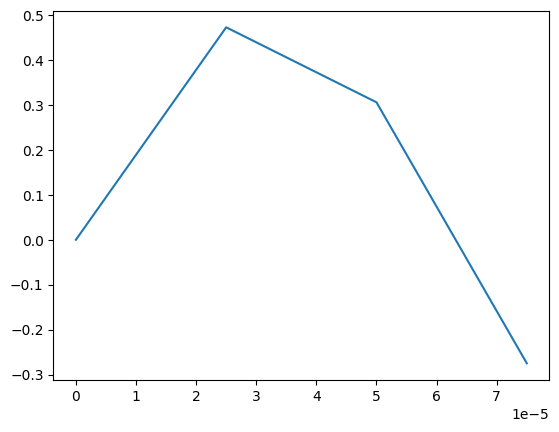

In [15]:
duration = note_roll[0].end_time - note_roll[0].start_time
t = np.linspace(0, duration, int(duration * rate), False)

wave1 = note_roll[0].generate_wave(rate)
wave2 = note_roll[1].generate_wave(rate)

plt.plot(t, wave1)
plt.plot(t, wave2)

plt.show()

479995


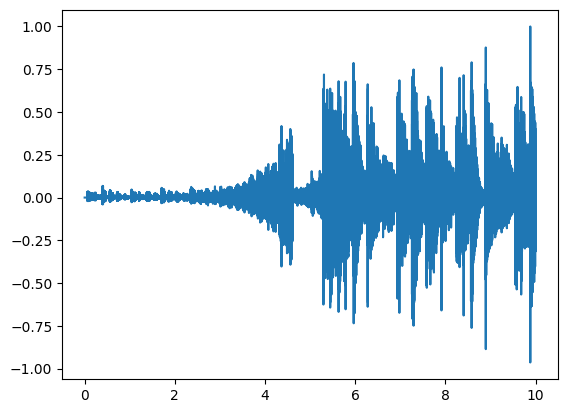

In [ ]:
note_samples = int(rate * 10.0)

wave = NoteUtilities.create_wave(note_roll, rate)

duration =  max(note.end_time for note in note_roll)

n_samples = int(duration * rate)

x = np.linspace(0, duration, n_samples, endpoint=False)

plt.plot(x, wave)

print(len(wave))

Let's listen and see how good the approximation in note-form is!

In [ ]:
from IPython.display import Audio

Audio(wave, rate=rate)